In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import statsmodels.api as sm
import seaborn as sns
import math
from datetime import datetime
import matplotlib.ticker as ticker
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler 

/home/sara/.local/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_42397/3364076871.py:4: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (

# Divide data by displacement reason

In [3]:
disp_data = pd.read_excel(r"/home/sara/Documenti/GitHub/Climate-and-conflict/displacements/UNHCR-PRMN-Displacement-Dataset - Somalia.xlsx")
states_gdf = gpd.read_file(r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/som_adm_ocha_itos_20230308_shp/som_admbnda_adm2_ocha_20230308.shp")
df_d = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/df_districts.csv")
#df_d = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/df_lags_2016_n4_disp_fd.csv")
distance = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/dist_som.csv")
pop_density = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/population_density.csv")

In [5]:
states_gdf.loc[~states_gdf['ADM2_EN'].isin(df_conc['Previous (Departure) District']), 'ADM2_EN'].unique()

NameError: name 'df_conc' is not defined

In [6]:
from haversine import haversine, Unit

states_gdf['ADM2_EN'].replace({'Baydhaba':'Baidoa','Kismaayo':'Kismayo'}, inplace=True)
states_gdf['centroid'] = states_gdf.geometry.centroid

# Initialize an empty DataFrame
dist_matrix = pd.DataFrame(index=states_gdf['ADM2_EN'], columns=states_gdf['ADM2_EN'])

# Calculate the haversine distance between each pair of districts
for i, dis1 in enumerate(states_gdf['ADM2_EN']):
    for j, dis2 in enumerate(states_gdf['ADM2_EN']):
        dist_matrix.loc[dis1, dis2] = haversine(states_gdf.loc[i, 'centroid'].coords[0], states_gdf.loc[j, 'centroid'].coords[0])

dist_matrix.to_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/dist_districts.csv")

/tmp/ipykernel_42397/4067426565.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  states_gdf['centroid'] = states_gdf.geometry.centroid


In [53]:
disp_data_d = disp_data[(disp_data['Reason']=='Drought related')]
disp_data_f = disp_data[(disp_data['Reason']=='Flood')]
disp_data_fd = disp_data[(disp_data['Reason']=='Drought related') | (disp_data['Reason']=='Flood')]
disp_data_c = disp_data[(disp_data['Reason']=='Conflict/Insecurity')]

agg_d=np.empty(4, dtype=object)
disp_matxs_d=np.empty(4, dtype=object)

for i,dd in enumerate([disp_data_d, disp_data_f, disp_data_fd, disp_data_c]):
    v= dd["Month End"]
    v=v.values
    dt = [datetime.strptime(v[j], "%d/%m/%Y") for j in range(len(v))]
    q=[]
    for j in range(len(dt)):
        q.append(datetime.timestamp(dt[j])) 
    dd.insert(loc=3, column='date_timestamp', value=q)
    dd=dd.sort_values("date_timestamp")
    dd['Month End'] = pd.to_datetime(dd['Month End'], dayfirst=True)

    #aggregate by district

    aggregated_data = dd.groupby([pd.Grouper(key='Month End', freq='M'), 'Previous (Departure) District', 'Current (Arrival) District']).agg({'Number of Individuals': 'sum', 'Current (Arrival) Region': 'first', 'Previous (Departure) Region': 'first'})
    dates = aggregated_data.index.get_level_values('Month End').unique()
    districts = aggregated_data.index.get_level_values('Previous (Departure) District').unique()
    all_combinations = pd.MultiIndex.from_product([dates, districts, districts], names=['time', 'Previous (Departure) District','Current (Arrival) District'])
    agg_d[i] = aggregated_data.reindex(all_combinations, fill_value=0).reset_index() 

    disp_matxs_d[i] = agg_d[i].pivot_table(index=['time','Previous (Departure) District'], columns='Current (Arrival) District', values='Number of Individuals', aggfunc='sum')
    disp_matxs_d[i]['year'] = disp_matxs_d[i].index.get_level_values('time').year

# to dictionary

agg_d = dict(zip(['drought', 'flood', 'flood_drought', 'conflict'], agg_d))
disp_matxs_d = dict(zip(['drought', 'flood', 'flood_drought', 'conflict'], disp_matxs_d))

In [54]:
districts = df_d['admin2'].unique()
district_codes = pd.factorize(districts)[0]
cmap = plt.cm.get_cmap('tab20', len(districts))

disp_matxs_d['drought']['year'] = disp_matxs_d['drought'].index.get_level_values('time').year
vac_lag = ['TA', 'TA_lag1', 'TA_lag2', 'TA_lag3', 'TA_lag4', 'TA_lag5']
lag_str = ['TA', 'TA_{lag1}', 'TA_{lag2}', 'TA_{lag3}', 'TA_{lag4}', 'TA_{lag5}']

/tmp/ipykernel_31257/1465952131.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(districts))


# Concatenate each destination 

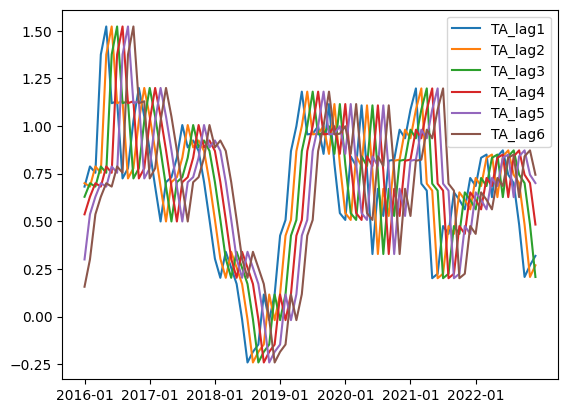

In [55]:
pl_1 = df_d[df_d['admin2']=='Banadir']

#plot TA, TA_lag1, .. against time in te same plot
fig, ax = plt.subplots()
#ax.plot(pl_1['time'], pl_1['sum_disp_lag1'], label='TA')
ax.plot(pl_1['time'], pl_1['TA_lag1'], label='TA_lag1')
ax.plot(pl_1['time'], pl_1['TA_lag2'], label='TA_lag2')
ax.plot(pl_1['time'], pl_1['TA_lag3'], label='TA_lag3')
ax.plot(pl_1['time'], pl_1['TA_lag4'], label='TA_lag4')
ax.plot(pl_1['time'], pl_1['TA_lag5'], label='TA_lag5')
ax.plot(pl_1['time'], pl_1['TA_lag6'], label='TA_lag6')
#change x axis to show only the years
ax.set_xticks(pl_1['time'][::12])
ax.legend()
plt.show()

# Concatenate each destination 

In [131]:
# DROUGHT all y

# List of elements to remove
remove_list = ['Baydhaba', 'Kismaayo']

# Using numpy.isin()
districts = districts[~np.isin(districts, remove_list)]

vec_d=[]
for j in districts:
    
    disp_ji = disp_matxs_d['drought'][j].reset_index()
    disp_ji['time'] = disp_ji['time'].dt.strftime('%Y-%m')
    dd = disp_ji.merge(df_d, how='inner', left_on=['time', 'Previous (Departure) District'], right_on=['time', 'admin2'])
    dd = dd.merge(df_d[df_d["admin2"] == j], how='inner', on=['time'], suffixes=('_dep', '_arr'))
    #dd = dd[dd[j]!=0]
    #dd = dd[dd['Previous (Departure) District']!=j]
    
    dd_melt= pd.melt(dd, id_vars=['time', 'Previous (Departure) District',
       'admin2_dep', 'tmx_dep', 'pre_dep', 'conflicts_dep', 'year_dep',
       'TA_dep', 'PA_dep', 'DL_dep', 'TA_lag1_dep', 'TA_lag2_dep',
       'TA_lag3_dep', 'TA_lag4_dep', 'TA_lag5_dep', 'TA_lag6_dep',
       'PA_lag1_dep', 'PA_lag2_dep', 'PA_lag3_dep', 'PA_lag4_dep',
       'PA_lag5_dep', 'PA_lag6_dep', 'DL_lag1_dep', 'DL_lag2_dep',
       'DL_lag3_dep', 'DL_lag4_dep', 'DL_lag5_dep', 'DL_lag6_dep',
       'conflicts_lag1_dep', 'conflicts_lag2_dep', 'conflicts_lag3_dep',
       'conflicts_lag4_dep', 'conflicts_lag5_dep', 'conflicts_lag6_dep',
       'sum_disp_dep', 'admin2_arr', 'tmx_arr', 'pre_arr', 'conflicts_arr',
       'TA_arr', 'PA_arr', 'DL_arr', 'TA_lag1_arr', 'TA_lag2_arr',
       'TA_lag3_arr', 'TA_lag4_arr', 'TA_lag5_arr', 'TA_lag6_arr',
       'PA_lag1_arr', 'PA_lag2_arr', 'PA_lag3_arr', 'PA_lag4_arr',
       'PA_lag5_arr', 'PA_lag6_arr', 'DL_lag1_arr', 'DL_lag2_arr',
       'DL_lag3_arr', 'DL_lag4_arr', 'DL_lag5_arr', 'DL_lag6_arr',
       'conflicts_lag1_arr', 'conflicts_lag2_arr', 'conflicts_lag3_arr',
       'conflicts_lag4_arr', 'conflicts_lag5_arr', 'conflicts_lag6_arr',
       'sum_disp_arr'],
       value_vars=[j+'_x'], var_name='Current (Arrival) District', value_name='Displacements')
    vec_d.append(dd_melt)

df_conc = pd.concat(vec_d, axis= 0, ignore_index=True)
df_conc.rename(columns={'year_dep':'year'}, inplace=True)
df_conc = df_conc[df_conc['Displacements']!=0]

In [134]:
#drop rows where TA_dep or Ta_arr is 0
df_conc = df_conc[df_conc['TA_dep']!=0]
df_conc = df_conc[df_conc['TA_arr']!=0]

,time,Previous (Departure) District,admin2_dep,tmx_dep,pre_dep,conflicts_dep,year,TA_dep,PA_dep,DL_dep,...,DL_lag6_arr,conflicts_lag1_arr,conflicts_lag2_arr,conflicts_lag3_arr,conflicts_lag4_arr,conflicts_lag5_arr,conflicts_lag6_arr,sum_disp_arr,Current (Arrival) District,Displacements
4774,2021-03,Adan Yabaal,Adan Yabaal,34.400000,18.85,0.0,2021,0.157298,0.139288,15,...,9.0,0.0,0.0,1.0,0.0,0.0,2.0,121.0,Adan Yabaal_x,115
4851,2021-04,Adan Yabaal,Adan Yabaal,33.800003,65.20,0.0,2021,-0.248754,0.172663,0,...,10.0,0.0,0.0,0.0,1.0,0.0,0.0,197.0,Adan Yabaal_x,197
5390,2021-11,Adan Yabaal,Adan Yabaal,32.700000,59.35,0.0,2021,0.104366,0.126130,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,Adan Yabaal_x,100
5467,2021-12,Adan Yabaal,Adan Yabaal,32.500000,20.05,0.0,2021,0.166407,0.112220,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,228.0,Adan Yabaal_x,221
5544,2022-01,Adan Yabaal,Adan Yabaal,32.650000,9.80,0.0,2022,0.323386,0.189595,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111.0,Adan Yabaal_x,111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484303,2022-11,Borama,Borama,29.700000,13.20,0.0,2022,1.138843,-0.088227,16,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,257.0,Zeylac_x,10
484345,2022-11,Lughaye,Lughaye,33.400000,9.80,0.0,2022,1.142411,-0.090951,16,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,257.0,Zeylac_x,131
484364,2022-11,Zeylac,Zeylac,32.600000,12.50,0.0,2022,1.123624,-0.071045,16,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,257.0,Zeylac_x,116
484417,2022-12,Lughaye,Lughaye,31.500000,1.40,0.0,2022,1.487571,-0.188400,17,...,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Zeylac_x,45


In [59]:
# CONFLICT all y
# # List of elements to remove
# remove_list = ['Dhahar', 'Sheikh']

# # Using numpy.isin()
# districts = districts[~np.isin(districts, remove_list)]

# vec_d=[]
# for j in districts:
    
#     disp_ji = disp_matxs_d['conflict'][j].reset_index()
#     disp_ji['time'] = disp_ji['time'].dt.strftime('%Y-%m')
#     dd = disp_ji.merge(df_d, how='inner', left_on=['time', 'Previous (Departure) District'], right_on=['time', 'admin2'])
#     dd = dd.merge(df_d[df_d["admin2"] == j], how='inner', on=['time'], suffixes=('_dep', '_arr'))
#     #dd = dd[dd[j]!=0]
#     dd = dd[dd['Previous (Departure) District']!=j]
    
#     dd_melt= pd.melt(dd, id_vars=['time', 'Previous (Departure) District',
#        'admin2_dep', 'tmx_dep', 'pre_dep', 'conflicts_dep', 'year_dep',
#        'TA_dep', 'PA_dep', 'DL_dep', 'TA_lag1_dep', 'TA_lag2_dep',
#        'TA_lag3_dep', 'TA_lag4_dep', 'TA_lag5_dep', 'TA_lag6_dep',
#        'PA_lag1_dep', 'PA_lag2_dep', 'PA_lag3_dep', 'PA_lag4_dep',
#        'PA_lag5_dep', 'PA_lag6_dep', 'DL_lag1_dep', 'DL_lag2_dep',
#        'DL_lag3_dep', 'DL_lag4_dep', 'DL_lag5_dep', 'DL_lag6_dep',
#        'conflicts_lag1_dep', 'conflicts_lag2_dep', 'conflicts_lag3_dep',
#        'conflicts_lag4_dep', 'conflicts_lag5_dep', 'conflicts_lag6_dep',
#        'sum_disp_dep', 'admin2_arr', 'tmx_arr', 'pre_arr', 'conflicts_arr',
#        'TA_arr', 'PA_arr', 'DL_arr', 'TA_lag1_arr', 'TA_lag2_arr',
#        'TA_lag3_arr', 'TA_lag4_arr', 'TA_lag5_arr', 'TA_lag6_arr',
#        'PA_lag1_arr', 'PA_lag2_arr', 'PA_lag3_arr', 'PA_lag4_arr',
#        'PA_lag5_arr', 'PA_lag6_arr', 'DL_lag1_arr', 'DL_lag2_arr',
#        'DL_lag3_arr', 'DL_lag4_arr', 'DL_lag5_arr', 'DL_lag6_arr',
#        'conflicts_lag1_arr', 'conflicts_lag2_arr', 'conflicts_lag3_arr',
#        'conflicts_lag4_arr', 'conflicts_lag5_arr', 'conflicts_lag6_arr',
#        'sum_disp_arr'],
#        value_vars=[j+'_x'], var_name='Current (Arrival) District', value_name='Displacements')
#     vec_d.append(dd_melt)

# df_conc = pd.concat(vec_d, axis= 0, ignore_index=True)
# df_conc.rename(columns={'year_dep':'year'}, inplace=True)
# df_conc = df_conc[df_conc['Displacements']!=0]

In [148]:
# form df_conc['Current (Arrival) District'] remove the lst '_x'
df_conc['Current (Arrival) District'] = df_conc['Current (Arrival) District'].str[:-2]

## GDP, pop_density and accessibility to cities

In [136]:
control = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/65fd61409be7ac28c56d5cb2_results.csv")
control = control[control.columns.drop(list(control.filter(regex='cru')))]
control['shapeName'].replace({'Baydhaba':'Baidoa','Kismaayo':'Kismayo'}, inplace=True)
control = control[['gdp_grid.none.mean','gpw_v4_rev11_count.2020.sum','shapeName']]
control.rename(columns={'gdp_grid.none.mean':'gdp_mean','gpw_v4_rev11_count.2020.sum':'pop_count'}, inplace=True)

df_conc = pd.merge(df_conc,control,how='left',left_on=['Current (Arrival) District'],right_on=['shapeName'])
df_conc = pd.merge(df_conc,control,how='left',left_on=['Previous (Departure) District'],right_on=['shapeName'], suffixes=('_arr', '_dep'))
df_conc.drop(['shapeName_dep','shapeName_arr'], axis=1, inplace=True)


In [138]:
df_conc.loc[~df_conc['Previous (Departure) District'].isin(control['shapeName']), 'Previous (Departure) District'].unique()

array([], dtype=object)

In [147]:
#drop rows where df_conc['admin2_dep'] or df_conc['admin2_arr'] is 'Badhan'
df_conc = df_conc[df_conc['Previous (Departure) District']!='Badhan']
df_conc = df_conc[df_conc['Current (Arrival) District']!='Badhan']
df_conc = df_conc[df_conc['Previous (Departure) District']!='Lasqoray']
df_conc = df_conc[df_conc['Current (Arrival) District']!='Lasqoray']

In [140]:
df_conc['dist_centroids']=df_conc.apply(lambda row: dist_matrix.loc[row['Previous (Departure) District'], row['Current (Arrival) District']], axis=1)

## Normalization

In [141]:
col2 =['conflicts_dep', 'TA_dep', 'PA_dep', 'DL_dep',
       'TA_lag1_dep', 'TA_lag2_dep', 'TA_lag3_dep', 'TA_lag4_dep',
       'TA_lag5_dep', 'TA_lag6_dep', 'PA_lag1_dep', 'PA_lag2_dep',
       'PA_lag3_dep', 'PA_lag4_dep', 'PA_lag5_dep', 'PA_lag6_dep',
       'DL_lag1_dep', 'DL_lag2_dep', 'DL_lag3_dep', 'DL_lag4_dep',
       'DL_lag5_dep', 'DL_lag6_dep', 'conflicts_lag1_dep',
       'conflicts_lag2_dep', 'conflicts_lag3_dep', 'conflicts_lag4_dep',
       'conflicts_lag5_dep', 'conflicts_lag6_dep', 'sum_disp_dep',
       'conflicts_arr', 'TA_arr', 'PA_arr', 'DL_arr', 'TA_lag1_arr',
       'TA_lag2_arr', 'TA_lag3_arr', 'TA_lag4_arr', 'TA_lag5_arr',
       'TA_lag6_arr', 'PA_lag1_arr', 'PA_lag2_arr', 'PA_lag3_arr',
       'PA_lag4_arr', 'PA_lag5_arr', 'PA_lag6_arr', 'DL_lag1_arr',
       'DL_lag2_arr', 'DL_lag3_arr', 'DL_lag4_arr', 'DL_lag5_arr',
       'DL_lag6_arr', 'conflicts_lag1_arr', 'conflicts_lag2_arr',
       'conflicts_lag3_arr', 'conflicts_lag4_arr', 'conflicts_lag5_arr',
       'conflicts_lag6_arr', 'gdp_mean_arr', 'pop_count_arr', 'gdp_mean_dep',
       'pop_count_dep', 'sum_disp_arr', 'Displacements', 'dist_centroids']

In [142]:
df_conc_norm = df_conc.copy()

min_max_scaler = MinMaxScaler().fit(df_conc[col2])
df_conc_norm[col2] = min_max_scaler.transform(df_conc[col2])

In [143]:
#find columns with -inf
df_conc_norm= df_conc_norm.replace(0, 0.001)

In [144]:
for col in col2:
    df_conc_norm[col + '_log'] = np.log(df_conc_norm[col])

/tmp/ipykernel_31257/211418274.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_conc_norm[col + '_log'] = np.log(df_conc_norm[col])
/tmp/ipykernel_31257/211418274.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_conc_norm[col + '_log'] = np.log(df_conc_norm[col])
/tmp/ipykernel_31257/211418274.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To g

In [146]:
#df_conc_norm.to_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/df_norm_districts_dist.csv", index=False)

In [7]:

df_no_ban = df_conc_norm[df_conc_norm['Current (Arrival) District']!='Banadir']
df_ban = df_conc_norm[df_conc_norm['Current (Arrival) District']=='Banadir']

#plt.plot(df_no_ban.groupby('time')['sum_disp'].sum(), label='No Banadir')
#plt.plot(df_ban.groupby('time')['sum_disp'].sum(), label='Banadir')

plt.plot(df_ban.groupby('time')['sum_disp'].sum().cumsum(), label='Destination: Banadir')
plt.plot(df_no_ban.groupby('time')['sum_disp'].sum().cumsum(), label='Destination: all other districts')
plt.xticks(np.arange(0, len(df_no_ban['time'].unique()), 13))
plt.xlabel('Time')
plt.ylabel('Cumulative displacements')
plt.title('Cumulative displacements (due to drought) to Banadir and other districts')
#invert order of labels in legend
plt.legend()
plt.show()

NameError: name 'df_conc_norm' is not defined

In [8]:
df_conc_norm['pop_count_arr']

NameError: name 'df_conc_norm' is not defined